# Chapter 6

## Question 8

Running best subset selection on simulated data

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd 
import itertools
import sklearn.linear_model
import statsmodels.api as sm

import matplotlib.pyplot as plt

sns.set(style="whitegrid")

### (a) Generate a predictor X of length n=100, as well as a noise vector $\epsilon$ of length n=100

In [2]:
x = np.random.normal(size=100)
eps = np.random.normal(size=100)


### (b) Generate a response vector Y according to the model ... (see below)

In [3]:
# Constants of your choice
b0 = 1
b1 = 2
b2 = 3
b3 = 4
y = b0 + b1*x + b2*np.square(x) + b3*np.power(x,3) + eps 

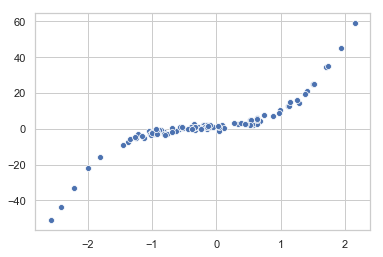

In [4]:
sns.scatterplot(x,y)

### (c) Perform best subset selection (they use `regsubsets()` in r) to choose the best model containing the predictors X, X^2, .... X^10. What is the best model according to $C_p$, BIC, and adjusted R? Show some plots to justify this, and report the coefficients of the best model.

In [5]:
# Create a data frame with X, X^2, X^3 ... X^10, and Y.

predictors = np.vstack([x, *(np.power(x,i) for i in range(2,11))]).T

df = pd.DataFrame(data=predictors, columns="x x2 x3 x4 x5 x6 x7 x8 x9 x10".split())
df["y"] = y
df.head()


,x,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,-0.138997,0.019320,-0.002685,0.000373,-5.188288e-05,7.211554e-06,-1.002383e-06,1.393280e-07,-1.936615e-08,2.691833e-09,-0.250418
1,-2.203740,4.856469,-10.702394,23.585291,-5.197584e+01,1.145412e+02,-2.524191e+02,5.562659e+02,-1.225865e+03,2.701488e+03,-33.195254
2,0.047922,0.002297,0.000110,0.000005,2.527486e-07,1.211229e-08,5.804491e-10,2.781646e-11,1.333029e-12,6.388184e-14,0.307092
3,0.336886,0.113492,0.038234,0.012881,4.339281e-03,1.461845e-03,4.924758e-04,1.659084e-04,5.589231e-05,1.882936e-05,2.751913
4,-0.315308,0.099419,-0.031348,0.009884,-3.116570e-03,9.826803e-04,-3.098472e-04,9.769740e-05,-3.080480e-05,9.713009e-06,0.537390


I have to implement best subset selection manually.


For k=1,2,...,p

- Fit all $p\choose{k}$ models with k predictors
- Pick the best among these, call it $M_k$. Define the best as having e.g. the smallest RSS (or highest $R^2$).
- Select the single best model from $M_0$ (the null model), $M_1$, $M_2$ etc, using cross-validated test error, $C_p$, BIC etc


In [6]:
# I have to implement best subset selection manually.
def get_linear_reg_score(X,Y):
    """Given X and Y, fit a linear model and return the R^2 score"""
    model = sklearn.linear_model.LinearRegression()
    model.fit(X,Y)
    Rsquared = model.score(X,Y)
    return Rsquared


bestPredictors = []

x_df = df.drop(columns=["y"])

p = len(x_df.columns)
for k in range(1,p+1):
    print(k)
    bestModelRss = 0
    bestColumns = None
    for subset in itertools.combinations(x_df.columns,k):
        rss = get_linear_reg_score(x_df[list(subset)],y)
        if rss > bestModelRss:
            bestModelRss = rss
            bestColumns = list(subset) 
    bestPredictors.append(bestColumns)

1
2
3
4
5
6
7
8
9
10


In [7]:
print(bestPredictors)

[['x3'], ['x2', 'x3'], ['x', 'x2', 'x3'], ['x', 'x2', 'x3', 'x4'], ['x', 'x3', 'x4', 'x6', 'x8'], ['x', 'x2', 'x3', 'x6', 'x8', 'x10'], ['x', 'x2', 'x3', 'x5', 'x6', 'x8', 'x10'], ['x', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x9'], ['x', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10'], ['x', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']]


In [8]:
# Select the best of these models, using C_p, AIC, BIC, or adjusted R^2
# Lets get all the above and plot them vs k.

# I'll switch to statsmodels for this

AICs = []
BICs = []
adjustedR2s = []
for i, cols in enumerate(bestPredictors):
    k = i+1
    model = sm.OLS(y, sm.add_constant(x_df[cols]))
    results = model.fit()
    AICs.append(results.aic)
    BICs.append(results.bic)
    adjustedR2s.append(results.rsquared_adj)

/home/will/.local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


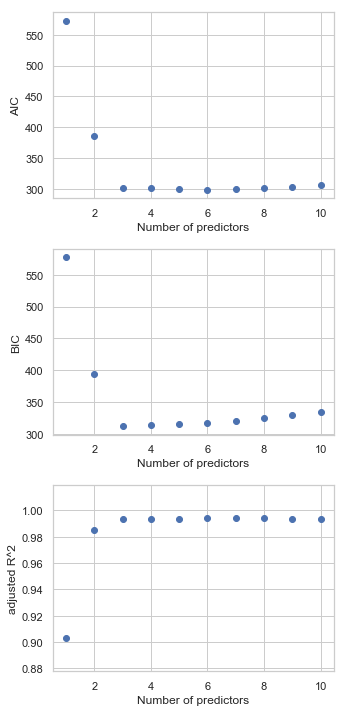

In [9]:
fig, axes = plt.subplots(nrows=3, figsize=(5,10))

scores = {"AIC":AICs, "BIC":BICs, "adjusted R^2":adjustedR2s}

for ax, score in zip(axes, scores.items()):
    score_name, score_data = score
    ax.scatter(range(1,11), score_data)
    ax.set_ylabel(score_name)
    ax.set_xlabel("Number of predictors")
plt.tight_layout()

Looks like the data supports 3 predictors (i.e. X, X^2, X^3) as expected

In [10]:
overallBestPredictors = bestPredictors[2]
overallBestPredictors

['x', 'x2', 'x3']

In [11]:
model = sklearn.linear_model.LinearRegression()
model.fit(x_df[overallBestPredictors],y)
print(f"predicted coefficients: {model.intercept_},", ", ".join(map(str, model.coef_)))
print(f"actual coefficients: {b0}, {b1}, {b2}, {b3}")


predicted coefficients: 1.0064879231335826, 2.2878758334402876, 2.9673812172739633, 3.9535057973114136
actual coefficients: 1, 2, 3, 4


### (d) Repeat (c) using forward stepwise selection and backward stepwise selection. How do the answers compare?

Forward stepwise selection:

For k=1,2,...,p

- Consider all $p - k$ models which augment the predictors in $M_k$ with one additional predictor.
- Pick the best among these models, and call it $M_k+1$. Define the best as having e.g. the smallest RSS (or highest $R^2$). 

Select the single best model from $M_0$ (the null model), $M_1$, $M_2$ etc, using cross-validated test error, $C_p$, BIC etc


In [12]:
x_df = df.drop(columns=["y"])

p = len(x_df.columns)
prev_predictors = []
for k in range(1,p+1):
    best_model_rss = 0
    best_predictor = None
    for col in x_df.columns.drop(prev_predictors):
        subset = prev_predictors + [col]
        rss = get_linear_reg_score(x_df[list(subset)],y)
        if rss > best_model_rss:
            best_model_rss = rss
            best_predictor = col
    prev_predictors.append(best_predictor)


In [13]:
# Select the best of these models, using AIC, BIC, or adjusted R^2
# Lets get all the above and plot them vs k.

# I'll switch to statsmodels for this

AICs = []
BICs = []
adjustedR2s = []
for i, _ in enumerate(prev_predictors):
    subset = prev_predictors[:i+1]
    model = sm.OLS(y, sm.add_constant(x_df[subset]))
    results = model.fit()
    AICs.append(results.aic)
    BICs.append(results.bic)
    adjustedR2s.append(results.rsquared_adj)

/home/will/.local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


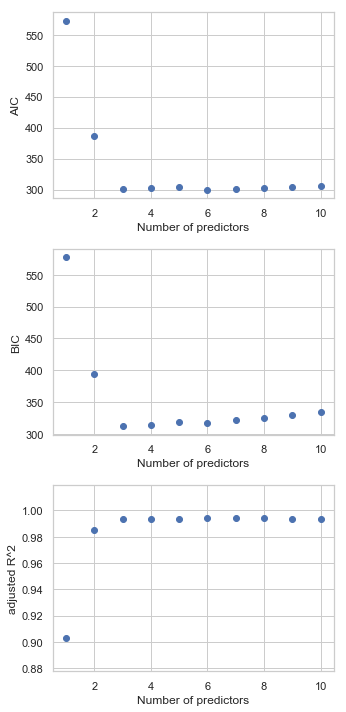

In [14]:
fig, axes = plt.subplots(nrows=3, figsize=(5,10))

scores = {"AIC":AICs, "BIC":BICs, "adjusted R^2":adjustedR2s}

for ax, score in zip(axes, scores.items()):
    score_name, score_data = score
    ax.scatter(range(1,11), score_data)
    ax.set_ylabel(score_name)
    ax.set_xlabel("Number of predictors")
plt.tight_layout()

In [15]:
# Looks like 3 predictors is the way to go. Which three are they?
prev_predictors[:3]

['x3', 'x2', 'x']

As before, the x, x^2, and x^3 terms are chosen.

Backward stepwise selection:

For k=p, p-1, ..., 2, 1

- Consider all $k$ models which contain all bar one of the predictors in $M_k$.
- Pick the best among these models, and call it $M_k-1$. Define the best as having e.g. the smallest RSS (or highest $R^2$). 

Select the single best model from $M_0$ (the null model), $M_1$, $M_2$ etc, using cross-validated test error, $C_p$, BIC etc


In [16]:
x_df = df.drop(columns=["y"])

p = len(x_df.columns)
predictor_list = []
predictors = x_df.columns
predictor_list.append(predictors)
while len(predictors) > 1:
    best_predictor = None
    best_model_rss = 0
    for col in predictors:
        subset_predictors = predictors.drop(col)
        rss = get_linear_reg_score(x_df[list(subset_predictors)],y)
        if rss > best_model_rss:
            best_model_rss = rss
            best_predictor = col
    predictors = predictors.drop(best_predictor)
    predictor_list.append(predictors)
    print(best_model_rss, "\t",  " ".join(map(str,predictors)))            

0.9944076492956302 	 x x2 x3 x4 x5 x7 x8 x9 x10
0.9944041456807071 	 x x2 x3 x4 x5 x7 x8 x9
0.9943371533115499 	 x x2 x3 x4 x7 x8 x9
0.9940418647772378 	 x x2 x3 x4 x7 x9
0.9940036927927036 	 x x2 x3 x7 x9
0.9939131077025918 	 x x2 x3 x9
0.9938566715851106 	 x x2 x3
0.9852883608173197 	 x2 x3
0.9039502895370419 	 x3


In [17]:
# Select the best of these models, using AIC, BIC, or adjusted R^2
# Lets get all the above and plot them vs k.

# I'll switch to statsmodels for this

AICs = []
BICs = []
adjustedR2s = []
for i, predictors in enumerate(predictor_list):
    model = sm.OLS(y, sm.add_constant(x_df[predictors]))
    results = model.fit()
    AICs.append(results.aic)
    BICs.append(results.bic)
    adjustedR2s.append(results.rsquared_adj)
    
AICs.reverse()
BICs.reverse()
adjustedR2s.reverse()

/home/will/.local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


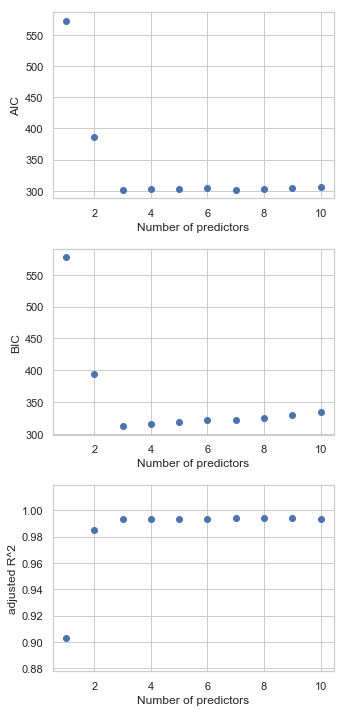

In [18]:
fig, axes = plt.subplots(nrows=3, figsize=(5,10))

scores = {"AIC":AICs, "BIC":BICs, "adjusted R^2":adjustedR2s}

for ax, score in zip(axes, scores.items()):
    score_name, score_data = score
    ax.scatter(range(1,11), score_data)
    ax.set_ylabel(score_name)
    ax.set_xlabel("Number of predictors")
plt.tight_layout()

As before, the x, x^2, and x^3 terms are chosen.

### (e) Now fit a lasso model to the simulated data, again using X, X^2, ...., X^10 as predictors. Use cross-validation to select the optimal $\lambda$ value. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates and discuss

In [19]:
# Use the LassoCV
lasso_model = sklearn.linear_model.LassoLarsCV(cv=5, max_iter=1e6)
lasso_model.fit(x_df,y)


LassoLarsCV(copy_X=True, cv=5, eps=2.220446049250313e-16, fit_intercept=True,
      max_iter=1000000.0, max_n_alphas=1000, n_jobs=None, normalize=True,
      positive=False, precompute='auto', verbose=False)

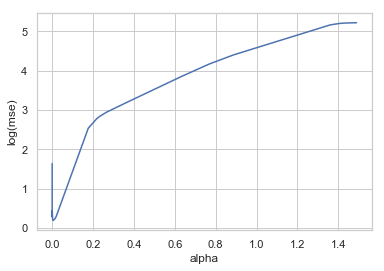

In [20]:
y = list(map(np.mean,lasso_model.mse_path_))
x = lasso_model.cv_alphas_
plt.plot(x,np.log(y))
plt.ylabel("log(mse)")
plt.xlabel("alpha")
plt.show()

In [21]:
coefficients = lasso_model.coef_path_

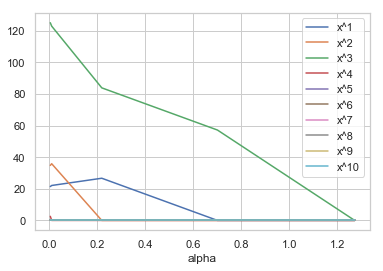

In [22]:
for i,coefficient in enumerate(coefficients):
    plt.plot(lasso_model.alphas_, coefficient, label=f"x^{i+1}")
plt.xlabel("alpha")
plt.legend()

In [23]:
lasso_model.alpha_

0.00432335449030581

In [24]:
lasso_model.coef_

array([2.23892744, 2.74548325, 3.96160305, 0.03931525, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [25]:
lasso_model.intercept_

1.1123122993485157

The lasso model has assigned the correct coefficients to $\beta_0$-$\beta_3$, and shrunk the remaining coefficients to zero

### (f) Now generate a response vector Y according to the model (see below) and perform best subset selection and the lasso. (presumably with powers of X up to 10 as before). Discuss.

In [26]:
x = np.random.normal(size=100)
eps = np.random.normal(size=100)
# Constants of your choice
b0 = 1
b7 = 7
y = b0 + b7*np.power(x,7) + eps 


In [27]:
# Create a data frame with X, X^2, X^3 ... X^10, and Y.
predictors = np.vstack([x, *(np.power(x,i) for i in range(2,11))]).T

x_df = pd.DataFrame(data=predictors, columns="x x2 x3 x4 x5 x6 x7 x8 x9 x10".split())


In [28]:
bestPredictors = []

p = len(x_df.columns)
for k in range(1,p+1):
    bestModelRss = 0
    bestColumns = None
    for subset in itertools.combinations(x_df.columns,k):
        rss = get_linear_reg_score(x_df[list(subset)],y)
        if rss > bestModelRss:
            bestModelRss = rss
            bestColumns = list(subset) 
    bestPredictors.append(bestColumns)

In [29]:
print(bestPredictors)

[['x7'], ['x7', 'x9'], ['x2', 'x6', 'x7'], ['x2', 'x3', 'x6', 'x7'], ['x3', 'x4', 'x7', 'x8', 'x10'], ['x', 'x3', 'x4', 'x7', 'x8', 'x10'], ['x', 'x3', 'x4', 'x5', 'x6', 'x7', 'x10'], ['x', 'x3', 'x4', 'x5', 'x6', 'x7', 'x9', 'x10'], ['x', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], ['x', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']]


In [30]:
# Select the best of these models, using C_p, AIC, BIC, or adjusted R^2
# Lets get all the above and plot them vs k.

# I'll switch to statsmodels for this

AICs = []
BICs = []
adjustedR2s = []
for i, cols in enumerate(bestPredictors):
    k = i+1
    model = sm.OLS(y, sm.add_constant(x_df[cols]))
    results = model.fit()
    AICs.append(results.aic)
    BICs.append(results.bic)
    adjustedR2s.append(results.rsquared_adj)

/home/will/.local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


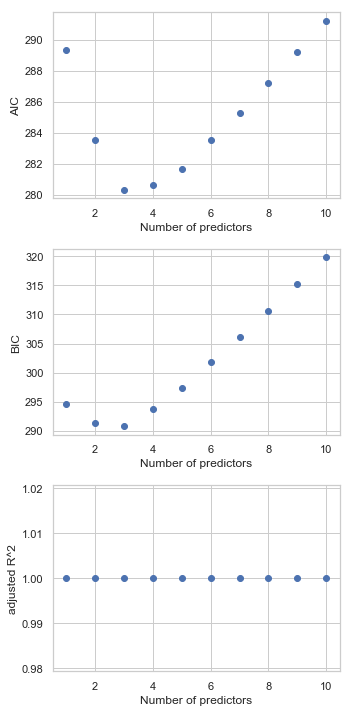

In [31]:
fig, axes = plt.subplots(nrows=3, figsize=(5,10))

scores = {"AIC":AICs, "BIC":BICs, "adjusted R^2":adjustedR2s}

for ax, score in zip(axes, scores.items()):
    score_name, score_data = score
    ax.scatter(range(1,11), score_data)
    ax.set_ylabel(score_name)
    ax.set_xlabel("Number of predictors")
plt.tight_layout()

AIC misbehaves, but it seems like 1 predictor is the best from the adjusted R^2

In [32]:
overallBestPredictors = bestPredictors[0]
overallBestPredictors

['x7']

In [33]:
model = sklearn.linear_model.LinearRegression()
model.fit(x_df[overallBestPredictors],y)
print(f"predicted coefficients: {model.intercept_},", ", ".join(map(str, model.coef_)))
print(f"actual coefficients: {b0}, {b7}")


predicted coefficients: 0.9653325427617858, 6.999678300212569
actual coefficients: 1, 7


#### And using lasso:

In [34]:
# Use the LassoCV
lasso_model = sklearn.linear_model.LassoLarsCV(cv=5, max_iter=1e6)
lasso_model.fit(x_df,y)


LassoLarsCV(copy_X=True, cv=5, eps=2.220446049250313e-16, fit_intercept=True,
      max_iter=1000000.0, max_n_alphas=1000, n_jobs=None, normalize=True,
      positive=False, precompute='auto', verbose=False)

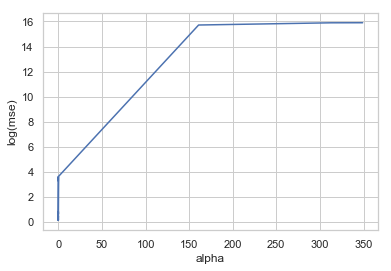

In [35]:
y = list(map(np.mean,lasso_model.mse_path_))
x = lasso_model.cv_alphas_
plt.plot(x,np.log(y))
plt.ylabel("log(mse)")
plt.xlabel("alpha")
plt.show()

In [36]:
coefficients = lasso_model.coef_path_

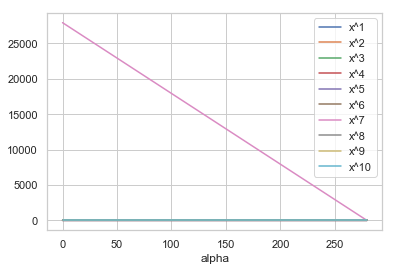

In [37]:
for i,coefficient in enumerate(coefficients):
    plt.plot(lasso_model.alphas_, coefficient, label=f"x^{i+1}")
plt.xlabel("alpha")
plt.legend()

In [38]:
lasso_model.alpha_

0.004572915664545062

In [39]:
lasso_model.coef_

array([ 0.00000000e+00, -4.83307159e-02,  0.00000000e+00,  0.00000000e+00,
        2.48923793e-02,  0.00000000e+00,  6.99712055e+00,  1.16857127e-04,
        0.00000000e+00,  0.00000000e+00])

In [40]:
lasso_model.intercept_

0.9924601280415857

Lasso has correctly assigned the coefficients, though it has also assigned non-zero but negligible coefficients to other powers of x